# 参考程序
<font size=4>该程序来源于https://zhuanlan.zhihu.com/p/33733586<br>
使用最新的sklearn库</font>

# 1.导入依赖包

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV,cross_val_score,learning_curve

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


G:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 2.导入数据

In [ ]:
train = pd.read_csv('../data/train.csv',dtype={"Age": np.float64})
test = pd.read_csv('../data/test.csv',dtype={"Age": np.float64})
PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)
train.info()
print('*'*10)
test.info()

# 3.数据可视化

In [ ]:
#性别特征
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')
print("Percentage of females who survived:%.2f" % (train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100))
print("Percentage of males who survived:%.2f" % (train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100))

In [ ]:
#乘客社会等级
sns.barplot(x="Pclass", y="Survived", data=train, palette='Set3')
print("Percentage of Pclass = 1 who survived:%.2f" % (train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 2 who survived:%.2f" % (train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 3 who survived:%.2f" % (train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100))

In [ ]:
#配偶以及兄弟姐妹数
sns.barplot(x="SibSp", y="Survived", data=train, palette='Set3')

In [ ]:
#父母和子女数
sns.barplot(x="Parch", y="Survived", data=train, palette='Set3')

In [ ]:
#年龄分布和生存下来的关系    kdeplot核密度分布图
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

In [ ]:
#船费和生存下来的关系
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 200))
facet.add_legend()

In [ ]:
#姓名中的称呼和生存下来的关系
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')

In [ ]:
#将SibSp和Parch两个参数汇总，家庭成员和生存下来的关系
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')

In [ ]:
#将家庭成员分为三类
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')

In [ ]:
#不同船舱与生存下来的关系，
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')     #使用Unknown填充缺失值
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')
#all_data['Cabin']

In [ ]:
#船票有一样的，设置团队票与生存下来的关系
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

In [ ]:
#将团队生存设置等级
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

# 4.数据清洗

In [15]:
#使用随机森林回归填充Age缺失值
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

In [16]:
#查看登录港口缺失值
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


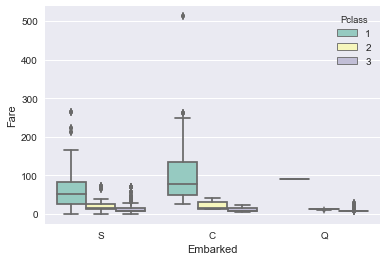

In [17]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass",data=all_data, palette="Set3")

In [18]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [19]:
#查看费用缺失值
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [20]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [21]:
#将姓氏相同的化为一组，分别提取出每组中的妇女，儿童和成年男性
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [22]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


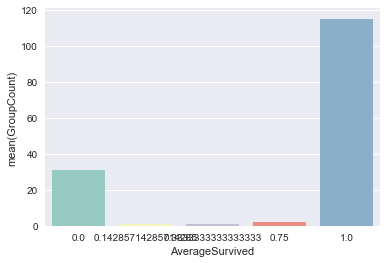

In [23]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"], palette='Set3').set_xlabel('AverageSurvived')

In [24]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


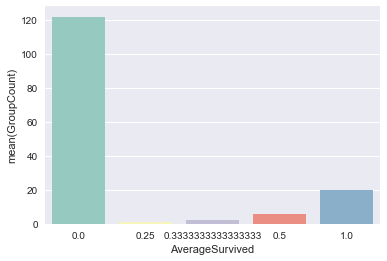

In [25]:
sns.barplot(x=Male_Adult.index, y=Male_Adult['GroupCount'], palette='Set3').set_xlabel('AverageSurvived')

In [26]:
#普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理
#把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Zabour', 'Boulos', 'Sage', 'Panula', 'Van Impe', 'Ilmakangas', 'Ford', 'Jussila', 'Bourke', 'Lahtinen', 'Lobb', 'Caram', 'Rosblom', 'Attalah', 'Cacic', 'Skoog', 'Robins', 'Barbara', 'Olsson', 'Rice', 'Johnston', 'Palsson', 'Strom', 'Lefebre', 'Danbom', 'Goodwin', 'Arnold-Franchi', 'Canavan', 'Vander Planke', 'Turpin', 'Oreskovic'}
{'Daly', 'Frolicher-Stehli', 'McCoy', 'Dick', 'Nakid', 'Taylor', 'Chambers', 'Duff Gordon', 'Cardeza', 'Frauenthal', 'Jussila', 'Kimball', 'Jonsson', 'Beane', 'Bishop', 'Beckwith', 'Harder', 'Goldenberg', 'Greenfield', 'Bradley'}


In [27]:
#对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

In [28]:
#特征转换，选取特征，转换为数值变量
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

# 5.建模和优化

In [29]:
#该函数用来绘制score学习曲线，参见sklearn example
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    #fill_between用来填充不同曲线周边的颜色
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    #绘制训练得分
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    #训练验证得分
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## --Adaboost模型

In [33]:
from sklearn.tree import DecisionTreeClassifier

#参数优化,使用管道机制找Adaboost最优参数
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', AdaBoostClassifier(DecisionTreeClassifier(),random_state=10))])
               
param_test ={'classify__base_estimator__max_depth':range(2,7,1),
            'classify__learning_rate':np.arange(0.01,0.2,0.01),
            'classify__n_estimators':range(50,200,2)}               
               
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__base_estimator__max_depth': 2, 'classify__learning_rate': 0.08, 'classify__n_estimators': 144} 0.8745081367580873


In [34]:
#训练模型
select = SelectKBest(k = 20)
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),learning_rate=0.08,n_estimators=144,random_state=10)
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x0000000010AFF268>)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_n...dom_state=None, splitter='best'),
          learning_rate=0.08, n_estimators=144, random_state=10))])

In [35]:
#交叉验证
cv_score = cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8351277 | Std - 0.04531288 


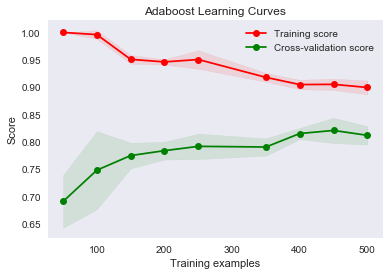

In [36]:
#模型验证
title = "Adaboost Learning Curves"
plot_learning_curve(pipeline, title, X,y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

In [40]:
#预测
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("../out/Adaboost_submission.csv", index=False)

##  --XGBoost模型

In [31]:
#参数优化,使用管道机制找XGBoost最优参数
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', XGBClassifier(silent=True, objective='binary:logistic'))])
               
param_test ={'classify__max_depth':range(2,7,1),
            'classify__learning_rate':np.arange(0.01,0.2,0.01),
            'classify__n_estimators':range(100,200,2)}               
               
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__learning_rate': 0.17, 'classify__max_depth': 2, 'classify__n_estimators': 122} 0.8811815937022248


In [38]:
#训练模型
select = SelectKBest(k = 20)
clf = XGBClassifier(learning_rate=0.17,max_depth=2,n_estimators=122,silent=True, objective='binary:logistic')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x0000000010AFF268>)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.17, max_delta_step=0,
       max_depth=2, min_child_weight=1, m...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [39]:
#交叉验证
cv_score = cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8406708 | Std - 0.04056789 


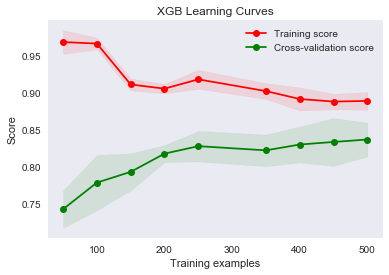

In [41]:
#模型验证
title = "XGB Learning Curves"
plot_learning_curve(pipeline, title, X,y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

In [42]:
#预测
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("../out/XGB_submission.csv", index=False)

## --随机森林模型

In [43]:
#参数优化,使用管道机制找随机森林最优参数
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 42} 0.8810963508395343


In [44]:
#训练模型
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x0000000010AFF268>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1...estimators=26, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=True))])

In [45]:
#交叉验证
cv_score = cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8451402 | Std - 0.03276752 


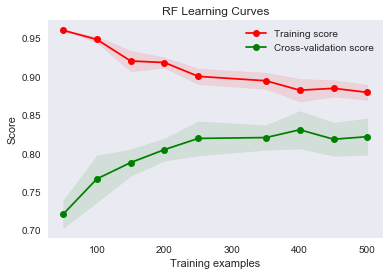

In [46]:
#模型验证
title = "RF Learning Curves"
# rf = RandomForestClassifier(n_estimators=500,min_samples_leaf=3,max_depth=6,oob_score=True)
plot_learning_curve(pipeline, title, X,y, cv=5,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

In [47]:
#预测
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("../out/RF_submission.csv", index=False)

# 6.预测

In [ ]:
#预测
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("../out/submission.csv", index=False)